In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from scipy import stats
import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.simplefilter(action="ignore")

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV,train_test_split
import math
import sklearn.model_selection as ms
import sklearn.metrics as sklm

pd.pandas.set_option('display.max_columns', None)

/kaggle/input/home-data-for-ml-course/sample_submission.csv
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/data_description.txt
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv
/kaggle/input/home-data-for-ml-course/test.csv


In [2]:
train = pd.read_csv('/kaggle/input/home-data-for-ml-course/train.csv.gz')

test = pd.read_csv('/kaggle/input/home-data-for-ml-course/test.csv.gz')

print(train.shape, test.shape)
train.head()

(1460, 81) (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## SalesPrice Feature Analysis

Lets Explore Target Feature i.e. SalesPrice

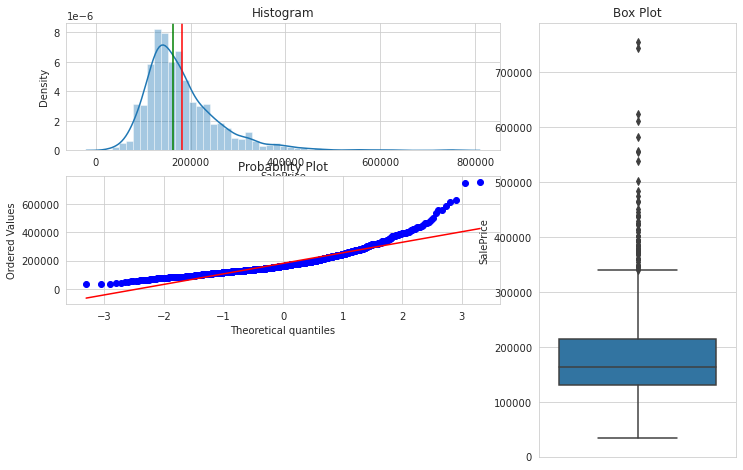

In [3]:
df = train
test_id = test['Id']

def three_chart_plot(df, feature):
    fig = plt.figure(constrained_layout = True, figsize = (12, 8))
    grid = gridspec.GridSpec(ncols = 3, nrows = 3, figure = fig)
    ax1 = fig.add_subplot(grid[0,:2])
    ax1.set_title('Histogram')
    
    sns.distplot(df.loc[:, feature], norm_hist = True, ax = ax1)
    plt.axvline(x = df[feature].mean(), c = 'red')
    plt.axvline(x = df[feature].median(), c = 'green')
    ax2 = fig.add_subplot(grid[1,:2])
    ax2.set_title('QQ_plot')
    stats.probplot(df.loc[:,feature], plot = ax2)
    
    ##Customizing the Box Plot
    ax3 = fig.add_subplot(grid[:,2])
    
    #Set title.
    ax3.set_title('Box Plot')
    sns.boxplot(x=None, y = df.loc[:, feature], orient = 'h', ax = ax3)
    
three_chart_plot(df, 'SalePrice')




Red line in histogram indicates the mean of the SalePrice and the Green line indicates the median

From the above plots, we can observe that the Sales Price is not normally distributed. From the boxplot we can observe that the dataset have a number of outliers.

For the probability plot, the red line represents those points which would have been plotted for y-axis points if those were normally distributed. But the blue points represents the actual scenario. We can see that there is a lot of deviation on the both the ends i.e on the top right and bottom left.


In [4]:
from scipy.stats import skew
print("Skewness of the SalesPrice is", df['SalePrice'].skew())

Skewness of the SalesPrice is 1.8828757597682129




Skewness refers to the amount of asymmetry in the given feature or in other words amount of distortions from the normal distribution.

Here we can observe that the value of skewness is quite high which means that there is a large amount of asymmetry.

The peak of the histogram represents the mode i.e the price for which maximum number of houses were sold.

What kind of skewness is present in the given case?

As the mean of the feature is greater than the median which is greater than the mode and the line is flat towards the right in the histogram, the given feature is Positively Skewed. Most of the houses were sold less than the average price


## NULL Values

There is an amazing library called missingno which helps us to visualize the number of Null values present in each feature.


<AxesSubplot:>

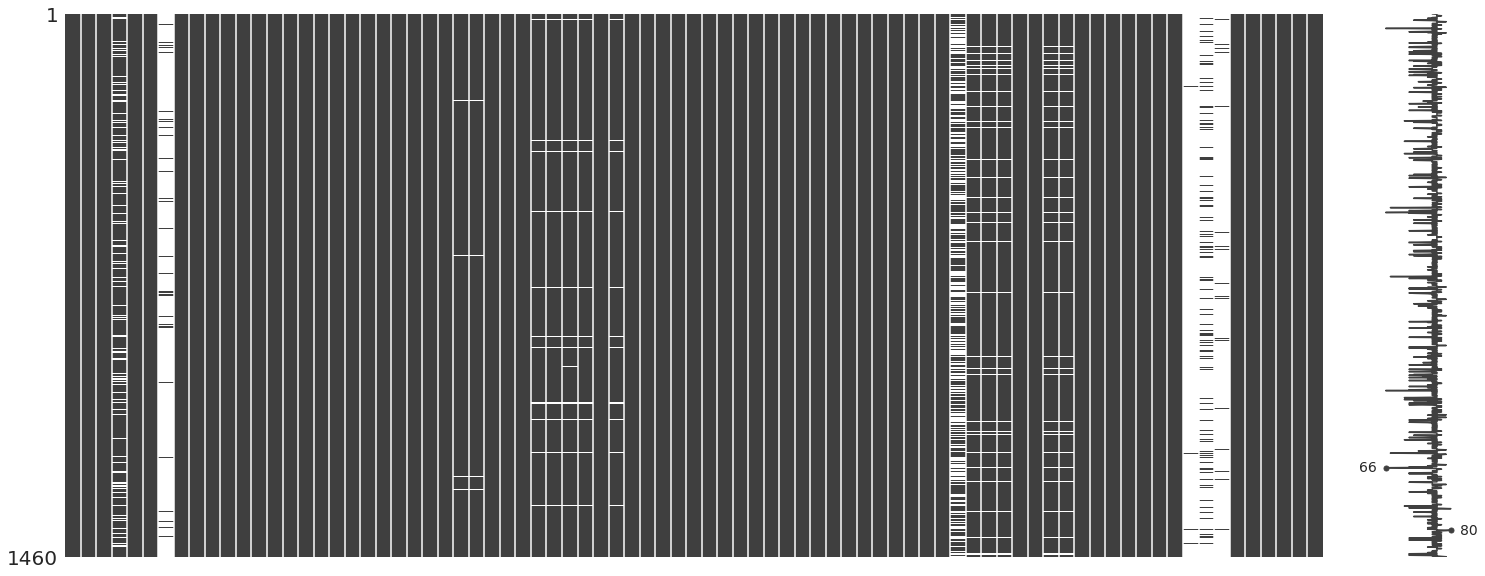

In [5]:
import missingno as msno
%matplotlib inline

msno.matrix(train)

<AxesSubplot:>

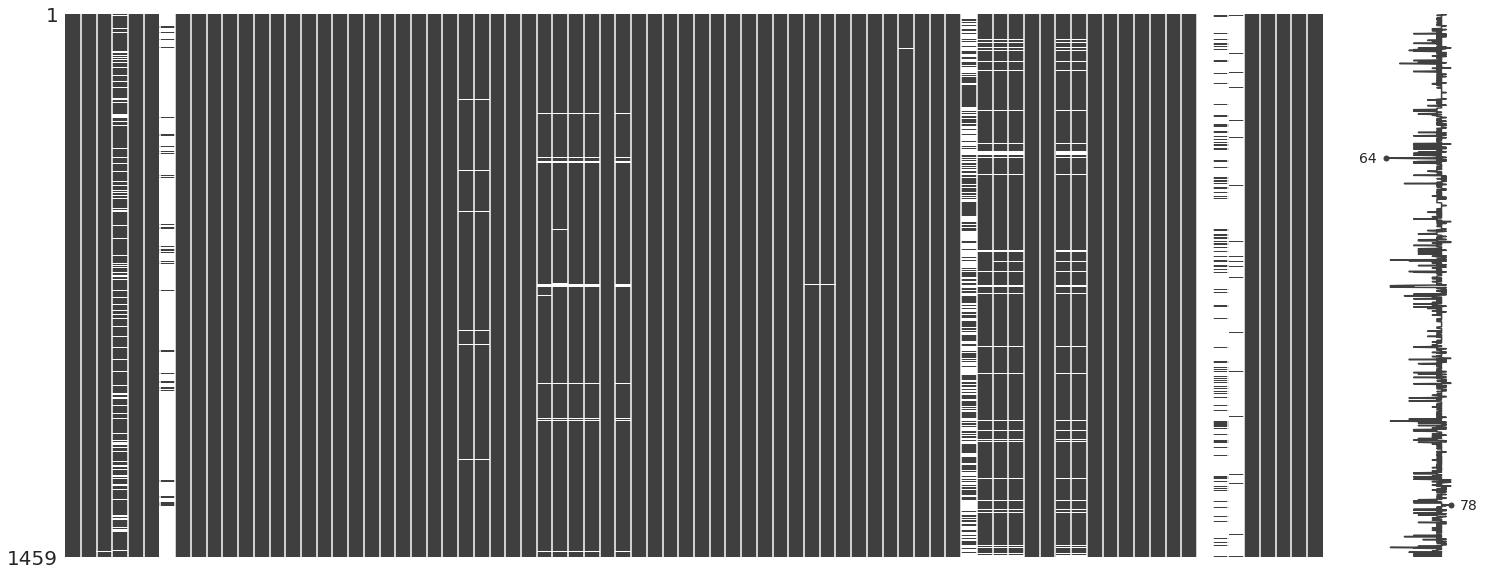

In [6]:
msno.matrix(test)

In [7]:
def null_table(dataframe):
        
    feature_with_na = [features for features in dataframe.columns if dataframe[features].isnull().sum()>=1]
    #values_with_na = [dataframe[features].isnull().sum() for features in dataframe.columns if dataframe[features].isnull().sum()>=1]
    
    para_null =[]
    values_with_na = []
    
    for features in feature_with_na:
        para_null.append(np.round(dataframe[features].isnull().mean(), 4) *100)
        values_with_na.append(dataframe[features].isnull().sum())
    
       
    d = {'Feature': feature_with_na, 'values': values_with_na, 'Percentage': para_null}
    
    null_frame = pd.DataFrame(data= d)
    return null_frame
                         

In [8]:
null_table_train = null_table(train)
null_table_train.sort_values(by='Percentage').tail(20)


,Feature,values,Percentage
9,Electrical,1,0.07
2,MasVnrType,8,0.55
3,MasVnrArea,8,0.55
4,BsmtQual,37,2.53
5,BsmtCond,37,2.53
7,BsmtFinType1,37,2.53
6,BsmtExposure,38,2.60
8,BsmtFinType2,38,2.60
15,GarageCond,81,5.55
14,GarageQual,81,5.55


In [9]:
null_table_test = null_table(test)
null_table_test

,Feature,values,Percentage
0,MSZoning,4,0.27
1,LotFrontage,227,15.56
2,Alley,1352,92.67
3,Utilities,2,0.14
4,Exterior1st,1,0.07
5,Exterior2nd,1,0.07
6,MasVnrType,16,1.10
7,MasVnrArea,15,1.03
8,BsmtQual,44,3.02
9,BsmtCond,45,3.08


We must observe here that NA has a different meaning. Here we can not impute or remove those rows having NA. For example if one of the values for Alley is NA, it means that home has no Alley or if the value of GarageType is NA it means that particular home has no Garage. That's why we need to take into account these values as it can affect the final prices of the house.


## Numerical and Categorical Variables
Exploring Numerical Variables

In [10]:
df.drop('Id',axis = 1, inplace =True)
category_var = df.select_dtypes(include = 'object')
num_var = df.select_dtypes(exclude = 'object')

print("Number of categorical features are: ", category_var.shape[1])
print("Number of numerical features are: ", num_var.shape[1])

Number of categorical features are:  43
Number of numerical features are:  37


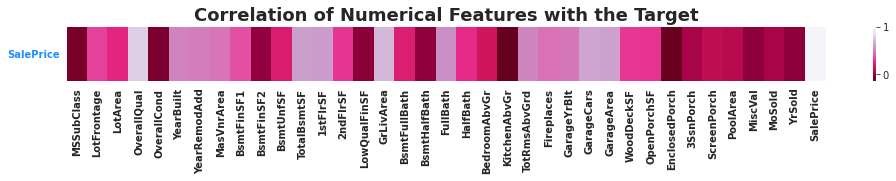

In [11]:
num = df.select_dtypes(exclude = 'object')
corr_num = num.corr()

f, ax = plt.subplots(figsize = (17, 1))

sns.heatmap(corr_num.sort_values(by = ['SalePrice'], ascending = False).head(1), cmap='PuRd_r')

plt.title('Correlation of Numerical Features with the Target', weight = 'bold', fontsize = 18)
plt.xticks(weight='bold')
plt.yticks(weight='bold', color='dodgerblue', rotation=0)

plt.show()



In [12]:
correlation = df.corr()['SalePrice'].sort_values(ascending = False).to_frame().head(10)

cmap = sns.light_palette("cyan", as_cmap = True)

s = correlation.style.background_gradient(cmap = cmap)

s

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897



From the above table, we can conclude that better the overall quality of the house, more will be the price of the house which is also true in real life. Same is true for the living area i.e as the area increases, more will be the Sale Price.

Let's plot a graph to examine the relationship between GrLivArea and the SalePrice


GrLivArea


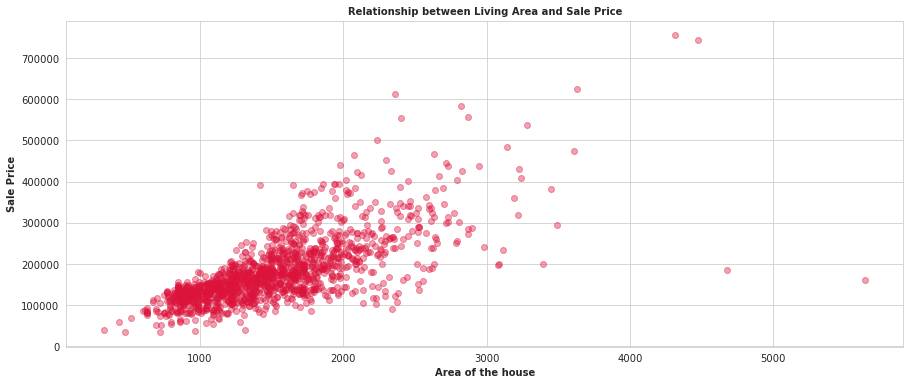

In [13]:
plt.figure(figsize = ((15, 6)))
plt.scatter(x = 'GrLivArea', y = 'SalePrice', data = df, color='crimson', alpha=0.4)
plt.title('Relationship between Living Area and Sale Price', weight = 'bold', fontsize = 10)
plt.xlabel('Area of the house', weight = 'bold')
plt.ylabel('Sale Price', weight = 'bold')
plt.show()

We can observe that there is almost a linear relationship between Living Area and the Sale Price. If the area is huge then price should also have also been high but the two rightmost points suggest something else. These two points are outliers. We will drop both of them below.

In [14]:
train = train[train['GrLivArea'] < 4500]
previous_train = df
df = train

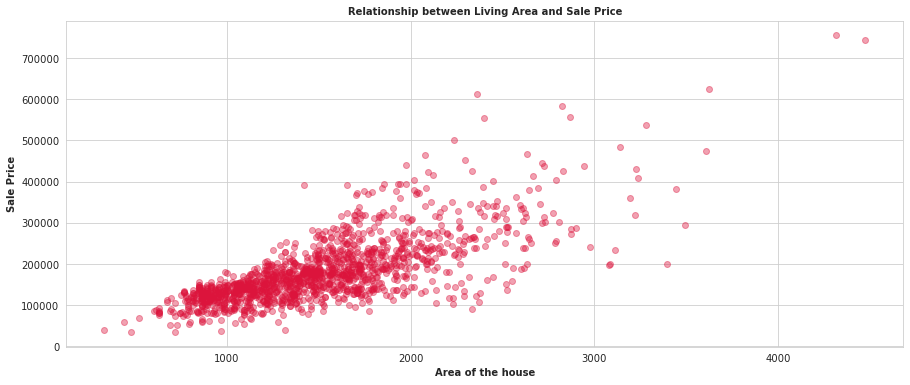

In [15]:
plt.figure(figsize = ((15, 6)))
plt.scatter(x = 'GrLivArea', y = 'SalePrice', data = df, color='crimson', alpha=0.4)
plt.title('Relationship between Living Area and Sale Price', weight = 'bold', fontsize = 10)
plt.xlabel('Area of the house', weight = 'bold')
plt.ylabel('Sale Price', weight = 'bold')
plt.show()



We can observe that those two values have been successfully dropped.



Garage Area


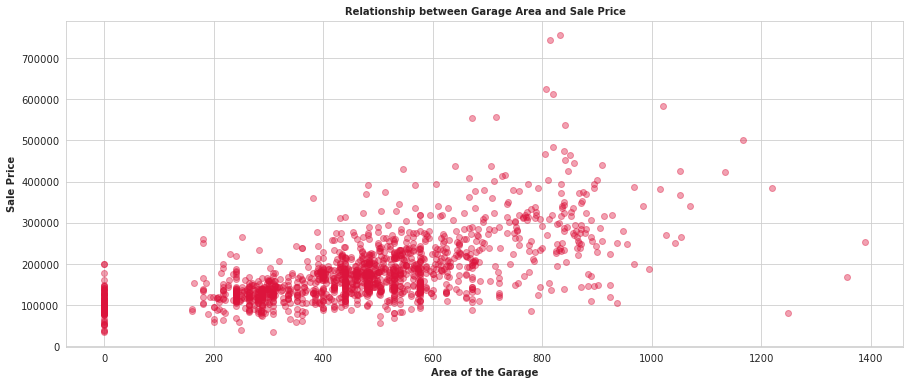

In [16]:
plt.figure(figsize = ((15, 6)))
plt.scatter(x = 'GarageArea', y = 'SalePrice', data = df, color='crimson', alpha=0.4)
plt.title('Relationship between Garage Area and Sale Price', weight = 'bold', fontsize = 10)
plt.xlabel('Area of the Garage', weight = 'bold')
plt.ylabel('Sale Price', weight = 'bold')
plt.show()

Total Basement Area

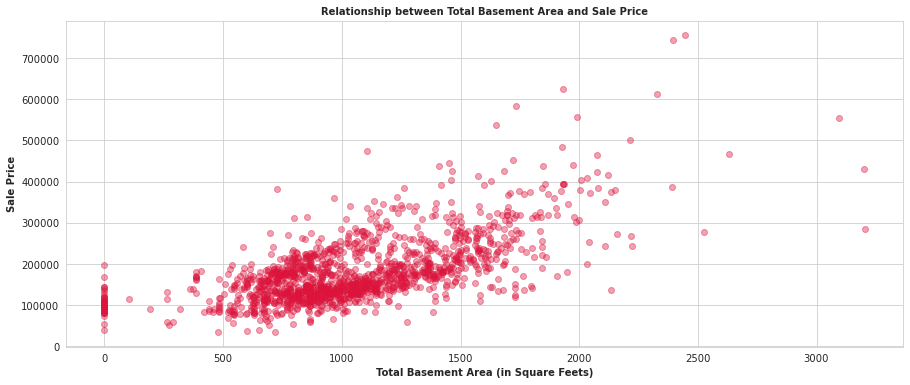

In [17]:
plt.figure(figsize = ((15, 6)))
plt.scatter(x = 'TotalBsmtSF', y = 'SalePrice', data = df, color = 'crimson', alpha = 0.4)
plt.title('Relationship between Total Basement Area and Sale Price', weight = 'bold', fontsize = 10)
plt.xlabel('Total Basement Area (in Square Feets)', weight = 'bold')
plt.ylabel('Sale Price', weight = 'bold')
plt.show()

1st Floor Area

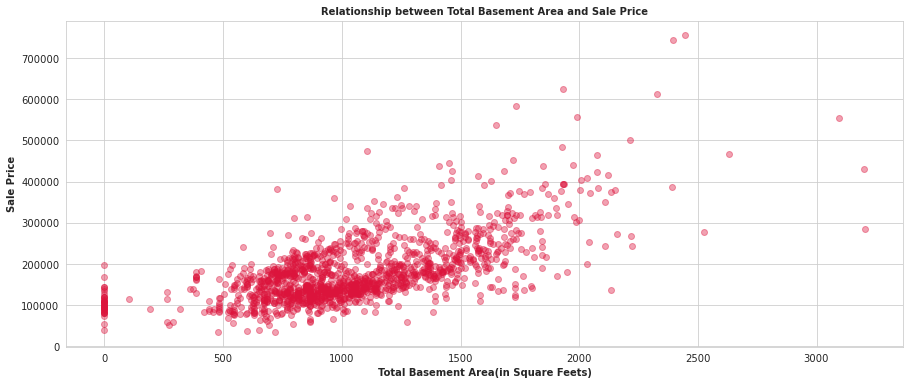

In [18]:
plt.figure(figsize = ((15, 6)))
plt.scatter(x = 'TotalBsmtSF', y = 'SalePrice', data = df, color = 'crimson', alpha = 0.4)
plt.title('Relationship between Total Basement Area and Sale Price', weight = 'bold', fontsize = 10)
plt.xlabel('Total Basement Area(in Square Feets)', weight = 'bold')
plt.ylabel('Sale Price', weight = 'bold')
plt.show()



Before we move forward we need to understand the assumptions of linear regression:

    Linearity
    Homoscedasticity
    No or little Multicollinearity
    Independence of Error

Since we fit a linear model, we assume that the relationship is linear, and the errors, or residuals, are pure random fluctuations around the true line. We expect that the variability in the dependent variable doesn't increase as the value of the independent increases, which is the assumptions of equal variance, also known as Homoscedasticity. We also assume that the observations are independent of one another(No Multicollinearity), and a correlation between sequential observations or auto-correlation is not there.

Now, these assumptions are prone to happen altogether. In other words, if we see one of these assumptions in the dataset, it's more likely that we may come across with others mentioned above. Therefore, we can find and fix various assumptions with a few unique techniques.

In order to discover the linearity let's plot scatter plots for GrLivArea and MasVnrArea


<AxesSubplot:xlabel='MasVnrArea', ylabel='SalePrice'>

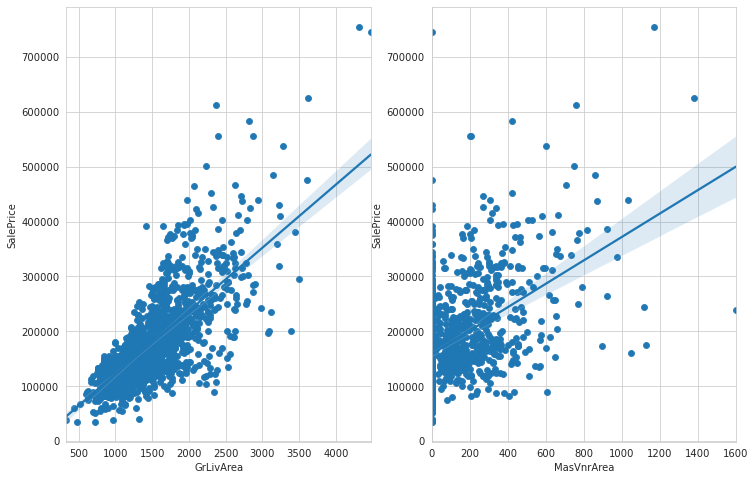

In [19]:
## Scatter plotting for SalePrice and GrLivArea.
fig, (ax1, ax2) = plt.subplots(figsize = (12, 8), ncols = 2,sharey = False)
 
sns.scatterplot(x = df['GrLivArea'], y = df['SalePrice'],  ax = ax1)
## Putting a regression line. 
sns.regplot(x = df['GrLivArea'], y = df['SalePrice'], ax = ax1)

sns.scatterplot(x = df['MasVnrArea'],y = df['SalePrice'], ax = ax2)
## regression line for MasVnrArea and SalePrice. 
sns.regplot(x = df['MasVnrArea'], y = df['SalePrice'], ax=ax2)



We can observe that the relationship between Sales Price and GrLivArea is much more linear than the relationship between Sales Price and MasVnrArea.

Let's look at the residual plot for independent variable GrLivArea and our target variable SalePrice.

A residual value is a measure of how much a regression line vertically misses a data point. Regression lines are the best fit of a set of data. You can think of the lines as averages; a few data points will fit the line and others will miss. A residual plot has the Residual Values on the vertical axis; the horizontal axis displays the independent variable.


<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

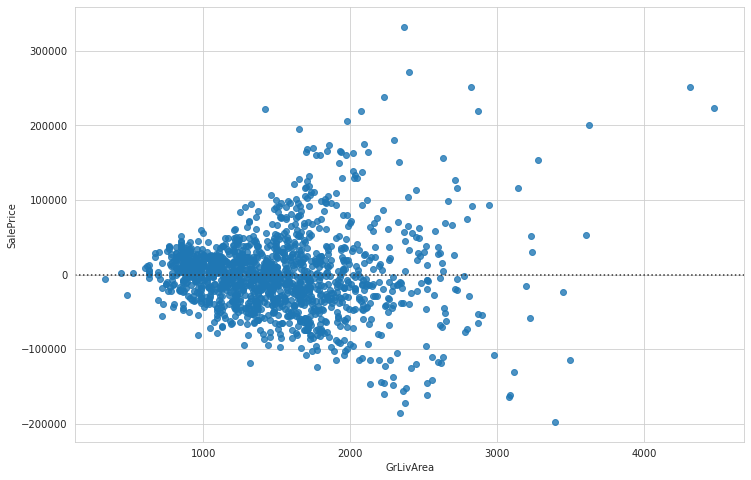

In [20]:
plt.subplots(figsize = (12,8))
sns.residplot(df['GrLivArea'], df['SalePrice'])



Ideally, if the assumptions are met, the residuals will be randomly scattered around the centerline of zero with no apparent pattern. The residual will look like an unstructured cloud of points centered around zero. However, our residual plot is anything but an unstructured cloud of points. Even though it seems like there is a linear relationship between the response variable and predictor variable, the residual plot looks more like a funnel.

The error plot shows that as GrLivArea value increases, the variance also increases, which is the characteristics known as Heteroscedasticity. The linear regression analysis requires the dependent variable to be multivariate normally distributed. A histogram, box plot, or a Q-Q-Plot can check if the target variable is normally distributed.

Let's plot the three graphs again for the target feature.


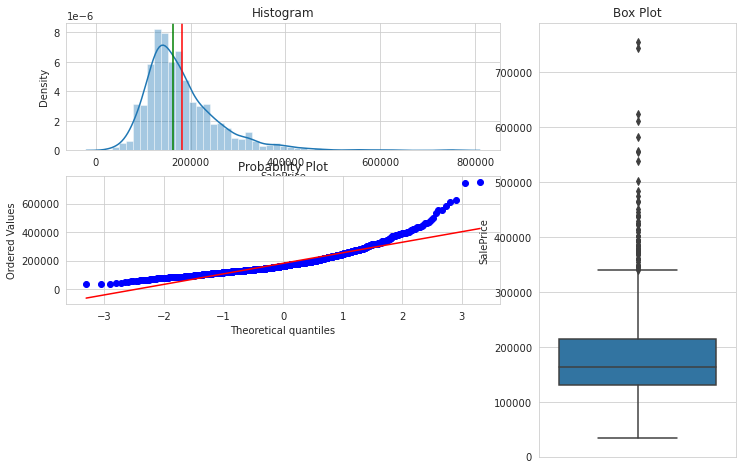

In [21]:
three_chart_plot(df, 'SalePrice')



Now let's make sure that the target variable follows a normal distribution. In order to make a feature follow normal distribution, we will perform log transformation.


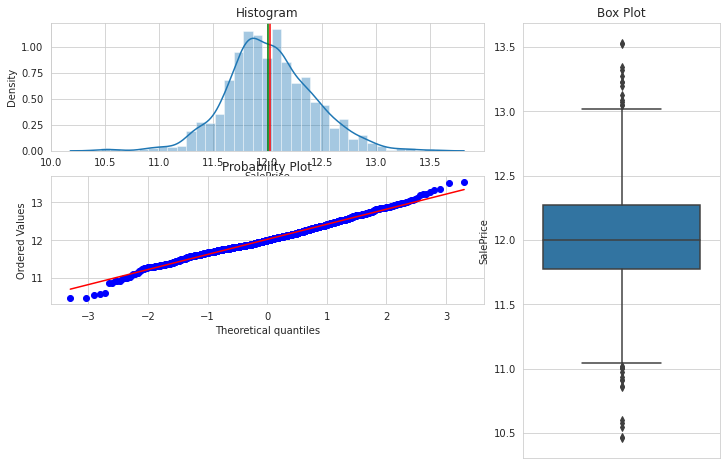

In [22]:
train["SalePrice"] = np.log1p(train["SalePrice"])
df = train
three_chart_plot(df, 'SalePrice')

We can observe that the SalesPrice feature now follows a normal distibution as the Histogram resembles bell-shape and the QQ-plot also overlaps with the red line. Let's again plot the scatter plot for GrLivArea and SalePrice to see whether Heteroscedasticity was removed.

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

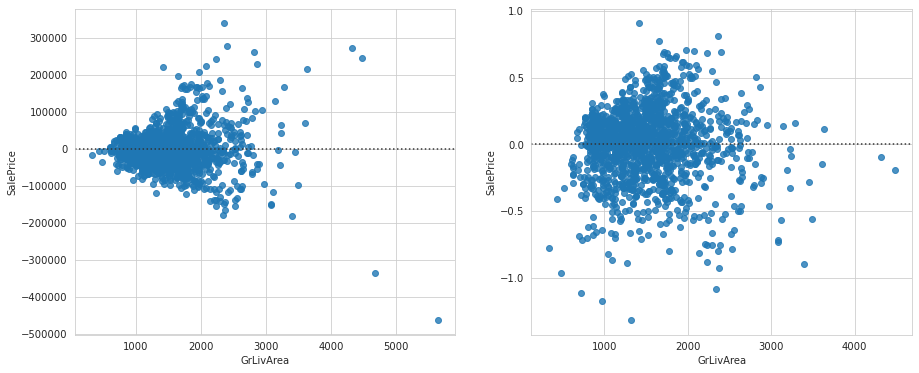

In [23]:
fig, (ax1, ax2) = plt.subplots(figsize = (15, 6),
                              ncols = 2,
                              sharey = False,
                              sharex = False)

sns.residplot(previous_train['GrLivArea'], previous_train['SalePrice'], ax = ax1)
sns.residplot(df['GrLivArea'], df['SalePrice'], ax = ax2)




We can see that the scatterplot on the left had heteroscedasticity(funnel like shape) but after applying log transformation to the feature, it was removed and now it's Homoscedastic.

Linear Regression indicates significant relationships between the dependent variable and the independent variable. It assumes that there is a linear relationship between the independent variables and the dependent variable but this is not always the case in real life. There are very less scenarios where this assumption holds true. Multiple Regression also suffers from multi-collinearity, auto-correlation, and heteroskedasticity.

The interpretation of the linear coefficient is that it represents the mean change in the dependent variable for 1 unit change in the independent variable when all the other independent variables are held constant.

Now suppose that there are two correlated independent variables (A and B) and we are aiming to find the right coefficient for these independent variables. When the coefficient for A is calculated, will that coefficient be accurate? No, it won’t be right because changes in A are associated with shifts in B, and as we have already discussed that all the other variables need to be held constant, B can’t be held as a constant because A and B are correlated. This is known as Multicollinearity and it is one of the disadvantages of Linear Regression.

In order to solve this problem, we use various regularization techniques (l1, l2 etc) or other kind of regression techniuques like Elastic Net Regression, Lasso and Ridge Regression which automatically takes care of multicollinearity.

<Figure size 1080x720 with 0 Axes>

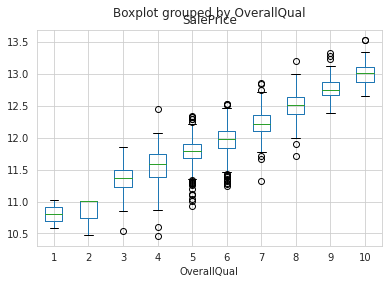

In [24]:
plt.figure(figsize = ((15, 10)))
df.boxplot(by = 'OverallQual', column = 'SalePrice')
plt.show()

Exploring Categorical variables

In [25]:
def horizontal_plot(data, column_name, color, plot_title):
    
    """
    A function that plots a horizontal bar graph for the given column name
    """
    
    fig, ax = plt.subplots(figsize = (9, 6))
    
    title_cnt = data[column_name].value_counts().sort_values(ascending = False).reset_index()

    mn = ax.barh(title_cnt.iloc[:, 0], title_cnt.iloc[:, 1], edgecolor = 'black', color =
                sns.color_palette(color, len(title_cnt)))

    for s in ['top','bottom','left','right']:
        ax.spines[s].set_visible(False)

    # Remove x,y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad=5)
    ax.yaxis.set_tick_params(pad=10)

    # Add x,y gridlines
    ax.grid(b=True, color='grey', linestyle='-.', linewidth=1, alpha=0.2)

    # Show top values 
    ax.invert_yaxis()

    ax.set_title(plot_title,weight='bold',loc='center', pad=10, fontsize=16)
    
    ax.set_xlabel('Count', weight='bold')

    for i in ax.patches:
        ax.text(i.get_width() + 1.0, i.get_y() + 0.5, str(round((i.get_width()), 2)),
                fontsize=10, fontweight='bold', color='grey')

    plt.yticks(weight='bold')
    plt.xticks(weight='bold')

    plt.show()

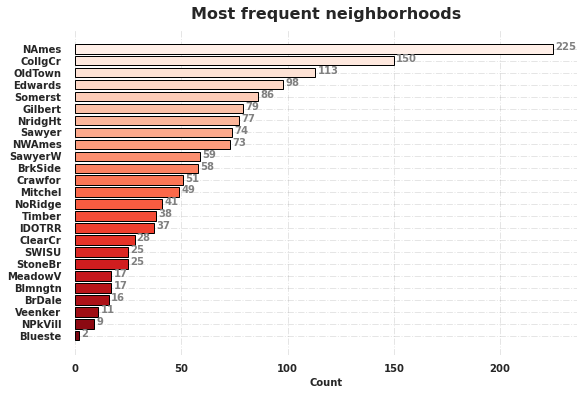

In [26]:
horizontal_plot(df, 'Neighborhood', 'Reds', 'Most frequent neighborhoods')

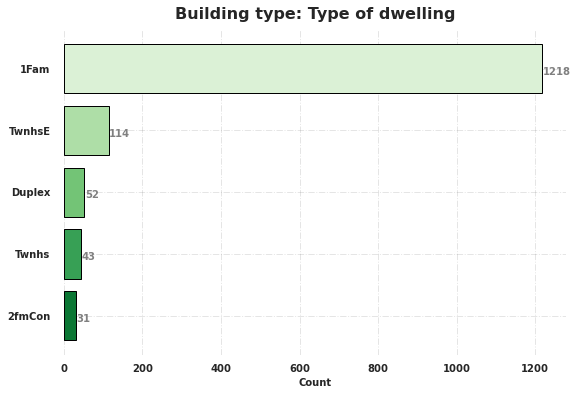

In [27]:
horizontal_plot(df, 'BldgType', 'Greens', 'Building type: Type of dwelling')

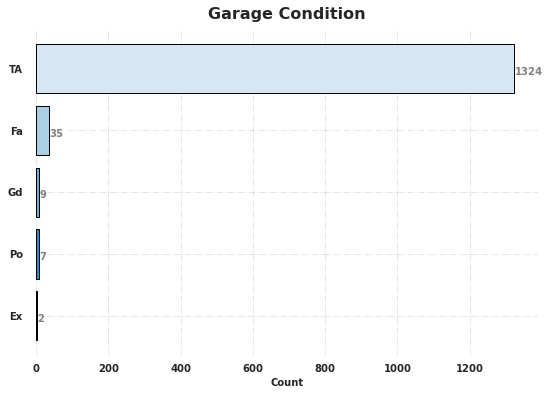

In [28]:
horizontal_plot(df, 'GarageCond', 'Blues', 'Garage Condition')

Most of the houses have Typically Average Garage Condition. Only couple of houses have Excellent Garage Condition.

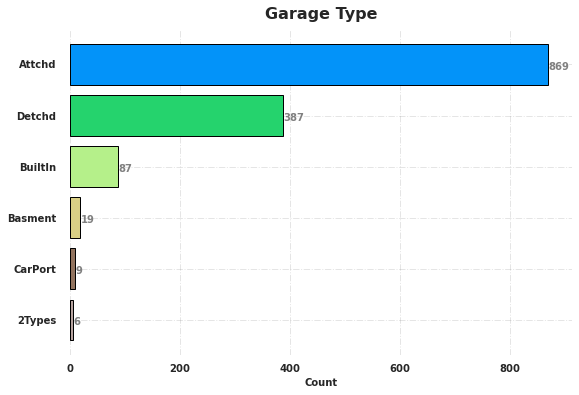

In [29]:
horizontal_plot(df, 'GarageType', 'terrain', 'Garage Type')



Most of the houses have Attached Garages and only 19 have Garages in the Basement


## Feature Engineering

First let's combine the train and test features.


In [30]:
y = df['SalePrice'].reset_index(drop = True)
train_features = df.drop('SalePrice', axis = 1)
test_features = test.copy()

features = pd.concat((train_features, test_features)).reset_index(drop = True)

In [31]:
features.shape

(2917, 80)

Some of the variables given in the description should be of string data type but instead they are stored as numerical data type. First let's change them into string data type

In [32]:
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['MoSold'] = features['MoSold'].astype(str)
features['YrSold'] = features['YrSold'].astype(str)

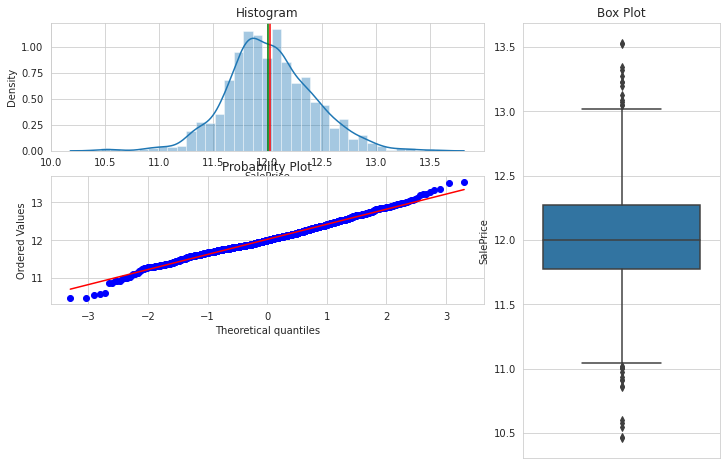

In [33]:
three_chart_plot(df, 'SalePrice')



Let' see the null values statistics of the combined dataset.


In [34]:
null_table(features).sort_values(by = 'Percentage').tail(10)

,Feature,values,Percentage
28,GarageQual,159,5.45
25,GarageFinish,159,5.45
24,GarageYrBlt,159,5.45
1,LotFrontage,486,16.66
22,FireplaceQu,1420,48.68
34,Id,1458,49.98
31,Fence,2346,80.43
2,Alley,2719,93.21
32,MiscFeature,2812,96.40
30,PoolQC,2908,99.69


In [35]:
features = features.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis = 1)
features.shape

(2917, 76)

In [36]:
features = features.drop(['Id'], axis = 1)
null_table(features).sort_values(by = 'Percentage').tail(10)

,Feature,values,Percentage
7,BsmtQual,81,2.78
8,BsmtCond,82,2.81
9,BsmtExposure,82,2.81
22,GarageType,157,5.38
28,GarageCond,159,5.45
23,GarageYrBlt,159,5.45
24,GarageFinish,159,5.45
27,GarageQual,159,5.45
1,LotFrontage,486,16.66
21,FireplaceQu,1420,48.68




We must observe here that NA has a different meaning. Here we can not impute or remove those rows having NA. For example if one of the values for Alley is NA, it means that home has no Alley or if the value of GarageType is NA it means that particular home has no Garage. That's why wee need to take into account these values as it can affect the final prices of the house.

I have identified some of the features which have NA as a category, they are listed in form of a list below. We will replace these null values with None.

Reading through the description of the features is very important, otherwise the above points can't be concluded.


In [37]:
discription = open('/kaggle/input/home-data-for-ml-course/data_description.txt','r')
print(discription.read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [38]:
features['MSZoning']

0       RL
1       RL
2       RL
3       RL
4       RL
        ..
2912    RM
2913    RM
2914    RL
2915    RL
2916    RL
Name: MSZoning, Length: 2917, dtype: object

In [39]:
def filling_null(features):
    
    # In the description for 'Functional Feature', it is given that Typ refers to the Typical Functionality
    # We will replace null values in the 'Functional' feature with 'Typ'
    
    features['Functional'] = features['Functional'].fillna('Typ')
    
    # Replace the null values in the below columns with their mode. We are replacing with mode because
    # all of these features are categorical variable, we can't take the mean nor the median.
    
    features['Electrical'] = features['Electrical'].fillna(features['Electrical'].mode()[0])
    
    features['KitchenQual'] = features['KitchenQual'].fillna(features['KitchenQual'].mode()[0])
    
    features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
    
    features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])

    features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
    
    # In order to fill the null values for MSZoing, we will take into account the MSSubClass featue.
    # We are doing so because the type of dwelling in a given area largely affects the zone of the area.
    
    features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    
    # In order to fill the null values for LotFrontage(Linear feet of street connected to property) 
    # we will fill it with median of the values grouped by Neighborhood.
    
    features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    
    # As mentioned before that the 'NA' value in many columns represent the absence of that feature for
    # a particular house, we will replace those null values with None.
    # 'None' for categorical feature and 0 for numerical feature.
    
    cat_features = features.select_dtypes(include = 'object').columns
    num_features = features.select_dtypes(exclude = 'object').columns
    
    features[cat_features] = features[cat_features].fillna('None')
    features[num_features] = features[num_features].fillna(0)
        
    return features

In [40]:
features = filling_null(features)
features.shape

(2917, 75)

In [41]:
features.isnull().sum().sum()

0

Now let's create some new features.

## Feature Creation

In [42]:
def new_features(features):
    
    features['HasPool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    features['Has2ndFloor'] = features['2ndFlrSF'].apply(lambda x : 1 if x > 0 else 0)
    features['HasGarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    features['HasBsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    features['HasFireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    
    # Adding total sqfootage features 
    # In order to get the total area of the house we have to add the basement area, 1st floor area and 2nd floor area.
    
    features['TotalSF'] = features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']
    
    # Total number of bathrooms = number of full bathrooms + 0.5 * number of half bathrooms
    # + number of bathrooms in basement + 0.5 * number of half bathrooms in the basement.
    
    features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                                   features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))
    
    features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                                  features['EnclosedPorch'] + features['ScreenPorch'])

    # Add years since remodel
    features['YearsSinceRemodel'] = features['YrSold'].astype(int) - features['YearRemodAdd'].astype(int)

    return features



We have added certain features which are quite intuitive and are taken into consideration in real life too while buying the house. Like what's the total area in square feet of the house or how many bathrooms are there in the house. We could also look for the availability of swimming pool, garage, fireplace and basement in the house. That's why I have added such features in the dataset

In [43]:
features = new_features(features)
features.shape

(2917, 84)



Let's analyse the skewness of the numerical features.


In [44]:
num_features = features.select_dtypes(exclude = 'object').columns

skewed_features = features[num_features].apply(lambda x : x.skew()).sort_values(ascending = False)
skew_features = pd.DataFrame({'Skew Value' : skewed_features})

skew_features.head(10)

,Skew Value
MiscVal,21.950962
PoolArea,17.697766
HasPool,15.502729
LotArea,13.116240
LowQualFinSF,12.090757
3SsnPorch,11.377932
KitchenAbvGr,4.302763
BsmtFinSF2,4.146636
EnclosedPorch,4.004404
ScreenPorch,3.947131


There's is quite a lot of asymmetry in the above features. We will need to fix the skewness

In [45]:
def fix_skew(features):
    
    from scipy.special import boxcox1p
    from scipy.stats import boxcox_normmax
    
    ## Getting all the data that are not of "object" type. 
    numerical_columns = features.select_dtypes(exclude = 'object').columns

    # Check the skew of all numerical features
    skewed_features = features[numerical_columns].apply(lambda x: x.skew()).sort_values(ascending=False)
    
    high_skew = skewed_features[abs(skewed_features) > 0.5]
    skewed_features = high_skew.index

    # Perform the Box-Cox transformation
    for column in skewed_features:
        features[column] = boxcox1p(features[column], boxcox_normmax(features[column] + 1))
        
    return features

In [46]:
features = fix_skew(features)
features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,HasPool,Has2ndFloor,HasGarage,HasBsmt,HasFireplace,TotalSF,Total_Bathrooms,Total_porch_sf,YearsSinceRemodel
0,60,RL,18.144574,13.833054,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,3.991517,2.737606e+51,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,19.433175,Gd,TA,PConc,Gd,TA,No,GLQ,144.117862,Unf,0.0,29.991055,422.488510,GasA,Ex,Y,SBrkr,5.939034,1025.651979,0.0,8.353543,0.99344,0.000000,2,1.068837,3,0.750957,Gd,2.261968,Typ,0.000000,None,Attchd,8.323081e+56,RFn,2.0,548.0,TA,TA,Y,0.000000,12.080309,0.000000,0.0,0.0,0.0,0.0,2,2008,WD,Normal,0.0,1,1.35127,41.797413,0,35.576146,3.5,12.339282,5
1,20,RL,20.673626,14.117918,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,6.000033,2.205231e+51,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,181.719186,Unf,0.0,44.135415,593.888179,GasA,Ex,Y,SBrkr,6.234991,0.000000,0.0,7.974693,0.00000,0.710895,2,0.000000,3,0.750957,TA,1.996577,Typ,0.903334,TA,Attchd,6.554016e+56,RFn,2.0,460.0,TA,TA,Y,56.184223,0.000000,0.000000,0.0,0.0,0.0,0.0,5,2007,WD,Normal,0.0,0,1.35127,41.797413,1,35.371880,2.5,0.000000,31
2,60,RL,18.668048,14.476512,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,3.991517,2.694373e+51,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,17.768840,Gd,TA,PConc,Gd,TA,Mn,GLQ,110.441033,Unf,0.0,56.896536,450.079716,GasA,Ex,Y,SBrkr,5.994336,1040.521060,0.0,8.408064,0.99344,0.000000,2,1.068837,3,0.750957,Gd,1.996577,Typ,0.903334,TA,Attchd,8.177961e+56,RFn,2.0,608.0,TA,TA,Y,0.000000,9.901081,0.000000,0.0,0.0,0.0,0.0,9,2008,WD,Normal,0.0,1,1.35127,41.797413,1,36.241065,3.5,10.090749,6
3,70,RL,17.249652,14.106196,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,3.991517,1.338013e+51,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,61.795315,Unf,0.0,64.808858,378.854568,GasA,Gd,Y,SBrkr,6.027705,904.477422,0.0,8.358662,0.99344,0.000000,1,0.000000,3,0.750957,Gd,2.137369,Typ,0.903334,Gd,Detchd,7.964750e+56,Unf,3.0,642.0,TA,TA,Y,0.000000,8.966115,16.020711,0.0,0.0,0.0,0.0,2,2006,WD,Abnorml,0.0,1,1.35127,41.797413,1,35.120717,2.0,28.165643,36
4,60,RL,21.314284,15.022008,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,3.991517,2.672997e+51,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,25.404164,Gd,TA,PConc,Gd,TA,Av,GLQ,136.624601,Unf,0.0,61.166379,545.309927,GasA,Ex,Y,SBrkr,6.161222,1273.024863,0.0,8.669321,0.99344,0.000000,2,1.068837,4,0.750957,Gd,2.373753,Typ,0.903334,TA,Attchd,8.106300e+56,RFn,3.0,836.0,TA,TA,Y,42.245702,14.271568,0.000000,0.0,0.0,0.0,0.0,12,2008,WD,Normal,0.0,1,1.35127,41.797413,1,39.002310,3.5,14.606322,8


In [47]:
features = pd.get_dummies(features).reset_index(drop=True)
features.shape

(2917, 324)

In [48]:
X = features.iloc[:len(y), :]
test = features.iloc[len(y):, :]

In [49]:
X.shape, test.shape, y.shape

((1458, 324), (1459, 324), (1458,))

Training and Testing Machine Learning Models

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [51]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [52]:
def evaluation(model, x_train_std, y_train, x_test, y_test, train = True):
    if train == True:
        pred = model.predict(x_train_std)
        
        print("Train Result:\n================================================")
        print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_train, pred))}")
        print("_______________________________________________")
        print(f"Mean Squared Error: {mean_squared_error(y_train, pred)}")
        print("_______________________________________________")
        print(f"Mean Absolute Error: \n{mean_absolute_error(y_train, pred)}")
        print("_______________________________________________")
        
    print()
    
    if train == False:
        pred = model.predict(x_test)
        
        print("Test Result:\n================================================")
        print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, pred))}")
        print("_______________________________________________")
        print(f"Mean Squared Error: {mean_squared_error(y_test, pred)}")
        print("_______________________________________________")
        print(f"Mean Absolute Error: \n{mean_absolute_error(y_test, pred)}")
        print("_______________________________________________")


## Lasso Regression

In [53]:
from sklearn.linear_model import Lasso
ls = Lasso(alpha = 0.1)
ls.fit(X_train, y_train)

evaluation(ls, X_train, y_train, X_test, y_test, True)
evaluation(ls, X_train, y_train, X_test, y_test, False)

Train Result:
Root Mean Squared Error: 0.17406961774139232
_______________________________________________
Mean Squared Error: 0.03030023182063444
_______________________________________________
Mean Absolute Error: 
0.12101728048554379
_______________________________________________


Test Result:
Root Mean Squared Error: 0.15620930561359683
_______________________________________________
Mean Squared Error: 0.024401347160282097
_______________________________________________
Mean Absolute Error: 
0.11449019123117647
_______________________________________________


## Ridge Regression

In [54]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha = 0.1)
ridge.fit(X_train, y_train)

evaluation(ridge, X_train, y_train, X_test, y_test, True)
evaluation(ridge, X_train, y_train, X_test, y_test, False)

Train Result:
Root Mean Squared Error: 0.08610797529338796
_______________________________________________
Mean Squared Error: 0.0074145834091267114
_______________________________________________
Mean Absolute Error: 
0.059791007744129994
_______________________________________________


Test Result:
Root Mean Squared Error: 0.11356234903600262
_______________________________________________
Mean Squared Error: 0.012896407118574885
_______________________________________________
Mean Absolute Error: 
0.08087794902364147
_______________________________________________


## XGBoost Regressor

In [55]:
import xgboost as xgb
xgb_regress = xgb.XGBRegressor(n_estimators = 1000, learning_rate = 0.1)
xgb_regress.fit(X_train, y_train)

evaluation(xgb_regress, X_train, y_train, X_test, y_test, True)
evaluation(xgb_regress, X_train, y_train, X_test, y_test, False)

Train Result:
Root Mean Squared Error: 0.001421682406033331
_______________________________________________
Mean Squared Error: 2.0211808636247206e-06
_______________________________________________
Mean Absolute Error: 
0.0009820412176178282
_______________________________________________


Test Result:
Root Mean Squared Error: 0.1168309894057129
_______________________________________________
Mean Squared Error: 0.0136494800855178
_______________________________________________
Mean Absolute Error: 
0.08399128064685449
_______________________________________________


In [56]:
test_pred = ridge.predict(test)
submission = pd.DataFrame(test_id, columns = ['Id'])
test_pred = np.expm1(test_pred)
submission['SalePrice'] = test_pred 
submission.head()

,Id,SalePrice
0,1461,118633.432981
1,1462,162220.717027
2,1463,189656.760398
3,1464,203191.161819
4,1465,205856.675258


In [57]:
submission.to_csv("result_ridge.csv", index = False, header = True)